# UMI sampling - what to expect

In this version of tRNA sequencing we use a UMI incorporated at the reverse transcription step.
The UMI has 9 random nt. and one purine nt. (i.e. choice between A and G).
This gives a total of $4^9x2 = 524,288$ possible unique sequence UMIs, and thus not nearly enough that the name "unique molecular identifier" is correct, because many molecules will be attached the same UMI sequence and several different molecules can be expected to be sequenced with the same UMI with sequencing depths at 1-6e6 reads per sample.

Regardless, the UMI serves a good purpose.
It helps to diversify the start of the read, thereby increasing Illumina sequencing quality, and it randomizes the sequence context for circular ligation, decreasing ligation bias.
And the unique UMI count can also be used to identify bottlenecks in the library prep as well as large amplification bias in the final PCR amplification step.

Currently, our way of interpretting the unique UMI count is by comparing it to the statistically expected count, assuming that these 524,288 possible unique UMI sequences occur with the same probability.
This is referred to as the observed vs. expected count, and is reported as a percentage.
However, random nt. in oligos are [not completely random](https://www.idtdna.com/pages/products/custom-dna-rna/mixed-bases).
How then should we think about the observed vs. expected count?
If a sample has 90 % observed vs. expected is that good or bad and how does it depend on the number of reads per sample?
For math majors specialized in combinatorics, these are questions that could probably be solved using pure algebra.
For the rest of us; we do a simulation study.

In this notebook, I will show a small simulation that can help build some intuition on how the observed vs. expected UMI count works and what variables influence its outcome.
In the real world the UMI is made of a string of A/T/G/C bases, in this simulation they are encoded as a list of the integers 0/1/2/3.

In [1]:
import pandas as pd
import bz2
import logomaker as lm
import numpy as np
from numpy.random import Generator, PCG64, SFC64, Philox
rng_pg = Generator(PCG64())
rng_sf = Generator(SFC64())
rng_ph = Generator(Philox())

In [2]:
### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [3]:
def ex_unique(n_bins, Ndraws):
    '''
    Expected number of unique elements when randomly drawing
    from a list with replacement containing elements with
    "n_bins" number of possiblities.
    
    See: https://stats.stackexchange.com/questions/296005/the-expected-number-of-unique-elements-drawn-with-replacement
    '''
    return(n_bins*(1-((n_bins-1) / n_bins)**Ndraws))

### Finding the fastest way of generating samples
In this section different methods are tested to find the fastest.
Each method could be a component in a simulation so finding the fastest is relevant to speed up the whole simulation.

A lot more dubious things were also tested but deleted for brevity.
Skip to the next section if you just care about the results.

In [148]:
# We need to use a hash table for speed.
# Quick test to see the fastest way of making the array hashable:
sample = np.random.randint(4, dtype=np.int8, size=(10))

In [149]:
%%timeit
hash(str(sample))

43.2 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [150]:
%%timeit
hash(sample.tobytes())

148 ns ± 2.6 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
# ^^ .tobytes() clearly the fastest!

In [184]:
# Battle different random number generators #
# Setting up a realistic test:
Nseqs = int(1e5) # Number of random draws
p_uni4 = np.array([0.25]*4) # Uniform prabability over 4 choices
p_uni2 = np.array([0.5]*2) # Uniform prabability over 2 choices
p_nonuni4 = np.array([0.20, 0.20, 0.3, 0.3])
p_nonuni2 = np.array([0.4, 0.6])
choices4 = np.arange(4, dtype=np.int8)
choices2 = np.arange(2, dtype=np.int8)

In [185]:
# Test on just integer generation #
%%timeit
a1 = rng_pg.integers(4, dtype=np.int8, size=(Nseqs, 9))
a2 = rng_pg.integers(2, dtype=np.int8, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

2.39 ms ± 49.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [186]:
# Test of sampling with replacement #
%%timeit
a1 = rng_pg.choice(choices4, p=p_uni4, size=(Nseqs, 9))
a2 = rng_pg.choice(choices2, p=p_uni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

23.4 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [187]:
%%timeit
a1 = rng_pg.choice(choices4, p=p_nonuni4, size=(Nseqs, 9))
a2 = rng_pg.choice(choices2, p=p_nonuni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

24.5 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
%%timeit
a1 = rng_sf.integers(4, dtype=np.int8, size=(Nseqs, 9))
a2 = rng_sf.integers(2, dtype=np.int8, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

2.28 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [189]:
%%timeit
a1 = rng_sf.choice(choices4, p=p_uni4, size=(Nseqs, 9))
a2 = rng_sf.choice(choices2, p=p_uni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

23.6 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [190]:
%%timeit
a1 = rng_sf.choice(choices4, p=p_nonuni4, size=(Nseqs, 9))
a2 = rng_sf.choice(choices2, p=p_nonuni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

23.6 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [191]:
%%timeit
a1 = rng_ph.integers(4, dtype=np.int8, size=(Nseqs, 9))
a2 = rng_ph.integers(2, dtype=np.int8, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

3.34 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [192]:
%%timeit
a1 = rng_ph.choice(choices4, p=p_uni4, size=(Nseqs, 9))
a2 = rng_ph.choice(choices2, p=p_uni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

28 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [193]:
%%timeit
a1 = rng_ph.choice(choices4, p=p_nonuni4, size=(Nseqs, 9))
a2 = rng_ph.choice(choices2, p=p_nonuni2, size=(Nseqs, 1))
samples = np.concatenate((a1.T, a2.T)).T

28.1 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Sampling with replacement from an input array is pretty slow (compared to integer generation), but necessary for this usecase.
Default PCG64 is pretty good.
Let us stick to that.

### Setting up and running the simulation

As mentioned above oligo random nt. are not truly indenpendent draws from a uniform distribution.
There are ways of violating the assumption of indenpendent draws from a uniform distribution.
One way is to violate independece, for example if a nucleotide on position 1 is going to influence the probability of nucleotides on subsequent positions.
The other is to violate the assumption of making the draws from a uniform distribution.
The problem of positional dependence, autocorrelation, or whatever it might be called, is hard to tackle but drawing from a non-uniform distribution is easy.
Therefore, I am going to maintain the assumption of positional independence but test the influence of drawing from a non-uniform distribution with nucleotide probabilities specified by an list such that: $P = (p_A, p_T, p_C, p_G), \sum P=1$  
The different nucletide probabilities ($p_A, p_T$ etc.) will be drawn as random numbers and the resulting standard deviation of $P$ will be used for ranking.

Consider the spread of nucleotide probabilities (standard deviation of $P$) as the first variable to test.
If the probabilies are equal, the spead is zero and the distribution is uniform.
But if the spread is large (e.g. $P = (0.025, 0.025, 0.05, 0.9)$) then it becomes very unlikely to encounter certain nucleotides, and very likely that some nucleotides appear again and again, thus increasing the chance of encountering duplicate UMIs.

The second variable to test is the number of sequence draws.
Consider this as the number of reads for each sample.
In the simulation, we will test different number of sequence draws and observe how this changes the observed vs. expected UMI count.

Below, I am setting up this simulation over the two mentioned variables.
The for each draw of $P$ there is made 30 evenly spaced (in log2 space) number of sequence draws and each of these simulations are replicated three times.

In [324]:
rand_nt = 9 # Number of random nt. (excluding the 10th nt.)
n_bins = 4**rand_nt * 2 # Number of possible sequences
Np_trials = 16 # Number of random draws of the base probabilities 
Nreps = 3 # Number of replicate runs (for confidence intervals)
# Number of different sized UMI sequence draws:
ran_size = 30
# range_int = np.linspace(30, 2e5, num=ran_size).astype(int)
# Make the draws evenly spaced in log2 space:
range_int = np.logspace(10, 23, num=ran_size, base=2).astype(int)

choices4 = np.arange(4, dtype=np.int8) # All 4 nt. choices
choices2 = np.arange(2, dtype=np.int8) # Just 2 nt. choices
p2 = np.array([0.5, 0.5]) # Assume uniform random for the last base
# Assume uniform random for the first run,
# then start drawing the probabilities from random:
p4 = np.array([0.25, 0.25, 0.25, 0.25])

# Store the counts and the standard deviations:
res_mat = np.zeros((ran_size, Nreps, Np_trials))
stdlist = list()
for p4_i in range(Np_trials): # Loop over the random draws of the base probabilities
    if p4_i > 0: # First run is using uniform base probabilities
        p4 = np.random.rand(1, 4)[0]
        p4 = p4/p4.sum()
    stdlist.extend([p4.std()]*ran_size)

    for rep in range(Nreps): # Loop over the replicates
        for res_i, Nseqs in enumerate(range_int): # Loop over the number of sequence draws
            # Generate the UMI sequences as two different matrices:
            a1 = rng_pg.choice(choices4, p=p4, size=(Nseqs, 9))
            a2 = rng_pg.choice(choices2, p=p2, size=(Nseqs, 1))
            # And concatenate them as one matrix of "samples"
            samples = np.concatenate((a1.T, a2.T)).T
            # Count the number of unique UMIs in the samples
            # using a set to deduplicate:
            UMI_set = set()
            for i in range(Nseqs):
                UMI_set.add(samples[i].tobytes())
            res_mat[res_i, rep, p4_i] = len(UMI_set)

    print('Standard deviation (x100) = {} for base probabilities: {}'.format(round(p4.std()*100, 3), str(p4)))

Standard deviation (x100) = 0.0 for base probabilities: [0.25 0.25 0.25 0.25]
Standard deviation (x100) = 12.207 for base probabilities: [0.4561452  0.17209921 0.14836225 0.22339334]
Standard deviation (x100) = 13.972 for base probabilities: [0.29280051 0.39386072 0.0185885  0.29475027]
Standard deviation (x100) = 13.931 for base probabilities: [0.02845829 0.29997813 0.41107294 0.26049064]
Standard deviation (x100) = 3.121 for base probabilities: [0.27526326 0.19654597 0.2630421  0.26514867]
Standard deviation (x100) = 10.488 for base probabilities: [0.28122004 0.0739242  0.35006323 0.29479254]
Standard deviation (x100) = 3.931 for base probabilities: [0.20198734 0.22112493 0.29505268 0.28183505]
Standard deviation (x100) = 9.645 for base probabilities: [0.10505988 0.36036379 0.30867084 0.22590549]
Standard deviation (x100) = 11.898 for base probabilities: [0.43553711 0.12149234 0.17643118 0.26653938]
Standard deviation (x100) = 19.212 for base probabilities: [0.28897602 0.54793925 0.0

Below the results of the simulation is restructured and the percentages of observed vs. expected unique UMIs are calculated.
Additionally, in one calculation it is assumed that 50 % of the UMI pool are duplicates and in another that 67 % are duplicates. 

In [325]:
# Some reshaping needs to happen because the matrix is 3D.
# We should have it as 2D with each block of results from
# the same base probabilities following each other:
res_mat_sh = res_mat.swapaxes(0,1).flatten(order='F').reshape((ran_size*Np_trials, Nreps), order='C')
# Turn into dataframe and add the number of 
res_df = pd.DataFrame(res_mat_sh)
res_df['Draws'] = list(range_int)*Np_trials
res_df['Prob_stdx100'] = [round(std*100, 3) for std in stdlist]

# Melt dataframe for plotting:
res_df = res_df.melt(id_vars=['Draws', 'Prob_stdx100'], var_name='Replicate', value_name='Obs')

# Calculate the % observed vs. expected 
# assuming all UMIs arose from different tRNA molecules: 
res_df['Exp_1'] = [ex_unique(n_bins, Nseqs) for Nseqs in res_df['Draws'].values]
res_df['Obs/Exp_1'] = 100*res_df['Obs']/res_df['Exp_1']

# Calculate the % observed vs. expected 
# assuming 50% of UMIs arose from the same tRNA molecules:
res_df['Exp_2'] = [ex_unique(n_bins, Nseqs*2) for Nseqs in res_df['Draws'].values]
res_df['Obs/Exp_2'] = 100*res_df['Obs']/res_df['Exp_2']

# Calculate the % observed vs. expected 
# assuming 67% of UMIs arose from the same tRNA molecules:
res_df['Exp_3'] = [ex_unique(n_bins, Nseqs*3) for Nseqs in res_df['Draws'].values]
res_df['Obs/Exp_3'] = 100*res_df['Obs']/res_df['Exp_3']

### Results

Below the results are plotted.
It is clear that increasing the spread of nucleotide probabilities also decreases the percentage of observed vs. expected, but it is very dependent upon the number of sequences drawn.
At very few sequences drawn, even with a large spread of nucleotide probabilities, the chance that all of them are unique is high and thus the percentage of observed vs. expected is close to 100 %.
The percentage of observed vs. expected is most sensitive to a large spead in nucleotide probabilities at around 700,000 to 1,000,000 sequence draws.
At much higher number of sequences drawn, even with a large spread of nucleotide probabilities, almost all unique UMIs have been observed and this percentage of observed vs. expected goes up again.

Now, just because the simulation was made usign realistic parameters these results are _not_ necessarily directly comparable to the observed vs. expected UMI data from actual tRNA sequencing samples.
These are just simulations and variables is such as positional dependence have been ignored.
To undertand the potential importance of ignoring positional dependence consider the extreme case resulting in homo nucleotide UMIs:  
`AAAAAAAAAA`  
`TTTTTTTTTT`  
`GGGGGGGGGG`  
`CCCCCCCCCC`  
If only these four UMIs were present in equal proportions, the positional distribution might look perfectly uniform i.e. each nucleotide has a frequency of 1/4 at each position.
However, the number of possible unique UMIs have decreased drastically.
Various degrees of positional dependence is likely to occur, so keep this in mind when interpreting these simulations.

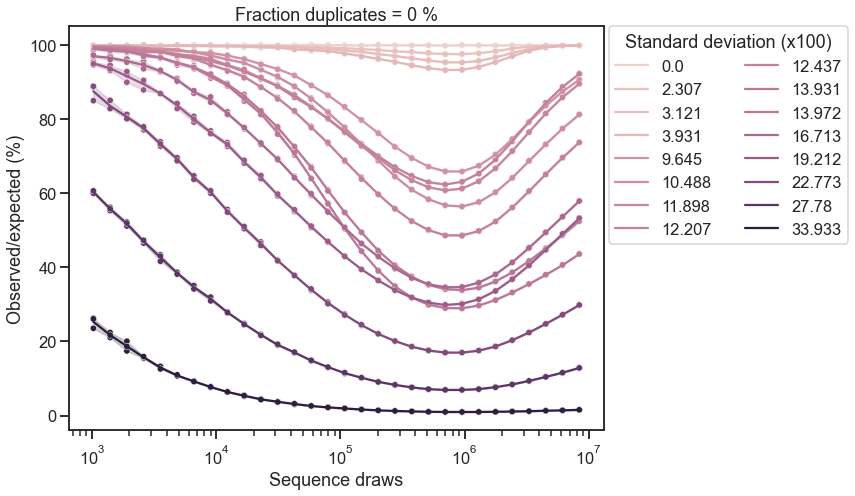

In [414]:
out_fnam = 'UMI_analysis_plots/UMI_count_analysis_obs-vs-exp_0p-duplication.pdf'

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

g1 = sns.lineplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_1', hue='Prob_stdx100', errorbar=('ci', 95), legend='full');
g2 = sns.scatterplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_1', hue='Prob_stdx100', legend=False, size=1);
g1.set_xscale('log')
g1.set_ylabel('Observed/expected (%)')
g1.set_xlabel('Sequence draws')
g1.set_title('Fraction duplicates = 0 %')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Standard deviation (x100)', bbox_to_anchor=(1.01,1), borderaxespad=0, ncol=2);

fig.tight_layout()
fig.savefig(out_fnam, bbox_inches='tight')

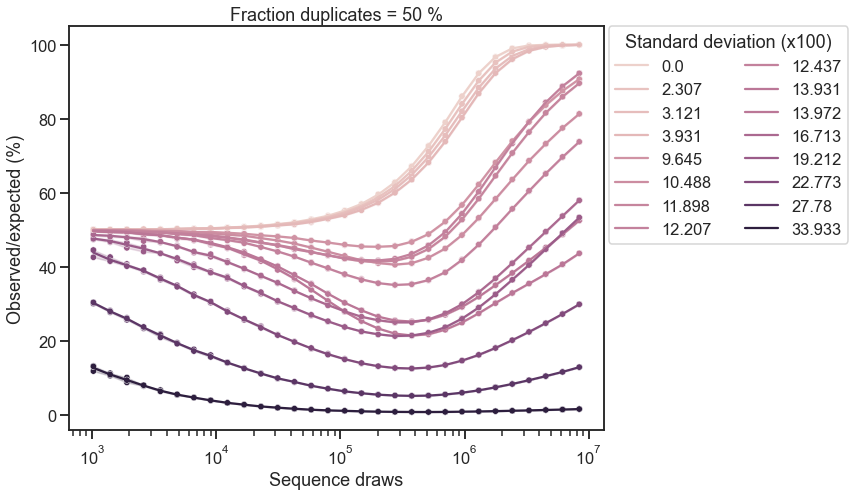

In [415]:
out_fnam = 'UMI_analysis_plots/UMI_count_analysis_obs-vs-exp_50p-duplication.pdf'

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

g1 = sns.lineplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_2', hue='Prob_stdx100', errorbar=('ci', 95), legend='full');
g2 = sns.scatterplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_2', hue='Prob_stdx100', legend=False, size=1);
g1.set_xscale('log')
g1.set_ylabel('Observed/expected (%)')
g1.set_xlabel('Sequence draws')
g1.set_title('Fraction duplicates = 50 %')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Standard deviation (x100)', bbox_to_anchor=(1.01,1), borderaxespad=0, ncol=2);

fig.tight_layout()
fig.savefig(out_fnam, bbox_inches='tight')

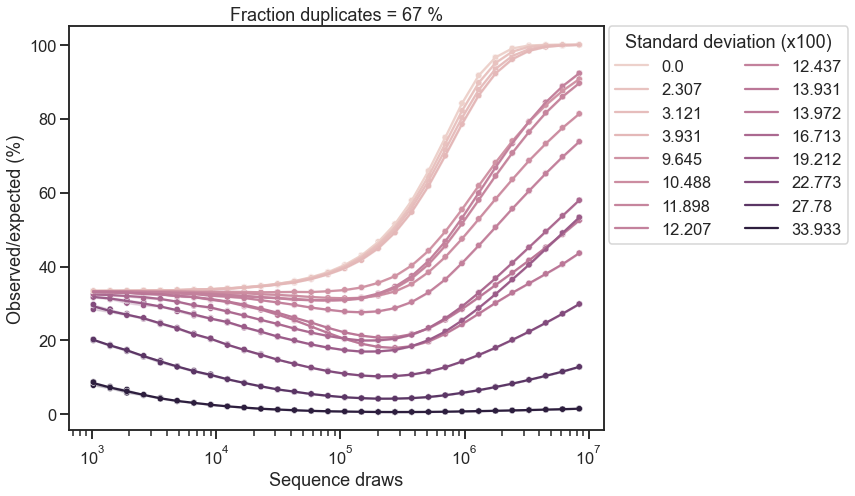

In [416]:
out_fnam = 'UMI_analysis_plots/UMI_count_analysis_obs-vs-exp_67p-duplication.pdf'

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

g1 = sns.lineplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_3', hue='Prob_stdx100', errorbar=('ci', 95), legend='full');
g2 = sns.scatterplot(ax=ax, data=res_df, x='Draws', y='Obs/Exp_3', hue='Prob_stdx100', legend=False, size=1);
g1.set_xscale('log')
g1.set_ylabel('Observed/expected (%)')
g1.set_xlabel('Sequence draws')
g1.set_title('Fraction duplicates = 67 %')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Standard deviation (x100)', bbox_to_anchor=(1.01,1), borderaxespad=0, ncol=2);

fig.tight_layout()
fig.savefig(out_fnam, bbox_inches='tight')

### Using real data

The problem with real data is that we don't really know how it was generated and therefore it is hard to make causal conclusions from observations alone.
So it is with UMIs encountered by sequencing: if we see a certain UMI pattern it is difficult to conclude if this arose from the oligo random nt. not being uniformly random, oligo random nt. positional dependence, the sample prep. before sequencing, the base calling during sequencing etc.
But of course it is still relevant to look at real data.

Here, I have isolated almost 8 million UMIs from real data (accross many samples), then deduplicated and counted them (for decreasing storage needs).
Below, I am reading these into an array with the duplicates expanded according to their count and shuffled.
Then, I perform a simulation similar to the above, but instead of generating the UMI randomly given a nucleotide probability vector $P$ (like above) the UMI is sampled from the UMI array.

In [4]:
# Read UMI data:
with bz2.open('UMI_list_counts.txt.bz2', 'rt') as fh_in:
    UMI_df = pd.read_csv(fh_in, names=['UMI', 'count'])

UMI_list = list()
for UMI, count in zip(UMI_df['UMI'].values, UMI_df['count'].values):
    UMI_list.extend([UMI]*count)

UMI_arr = np.array(UMI_list)
np.random.shuffle(UMI_arr)
del UMI_list

In [5]:
N_UMI = len(UMI_arr)
idx_arr = np.arange(N_UMI)
n_bins = 4**9 * 2 # Number of possible sequences
Nreps = 6 # Number of replicate runs (for confidence intervals)
# Number of different sized UMI sequence draws:
ran_size = 30
# range_int = np.linspace(30, 2e5, num=ran_size).astype(int)
# Make the draws evenly spaced in log2 space:
range_int = np.logspace(10, 22.9, num=ran_size, base=2).astype(int)

# Store the counts and the standard deviations:
res_mat = np.zeros((ran_size, Nreps))

for rep in range(Nreps): # Loop over the replicates
    for res_i, Nseqs in enumerate(range_int): # Loop over the number of sequence draws
        inds = rng_pg.choice(idx_arr, size=(Nseqs), replace=False)
        UMI_set = set(np.take(UMI_arr, inds))
        res_mat[res_i, rep] = len(UMI_set)

    print('At replicate: {}'.format(rep))

At replicate: 0
At replicate: 1
At replicate: 2
At replicate: 3
At replicate: 4
At replicate: 5


In [6]:
# Turn into dataframe and add the number of 
res_df_real = pd.DataFrame(res_mat)
res_df_real['Draws'] = list(range_int)

# Melt dataframe for plotting:
res_df_real = res_df_real.melt(id_vars=['Draws'], var_name='Replicate', value_name='Obs')

# Calculate the % observed vs. expected 
# assuming all UMIs arose from different tRNA molecules: 
res_df_real['Exp'] = [ex_unique(n_bins, Nseqs) for Nseqs in res_df_real['Draws'].values]
res_df_real['Obs/Exp'] = 100*res_df_real['Obs']/res_df_real['Exp']

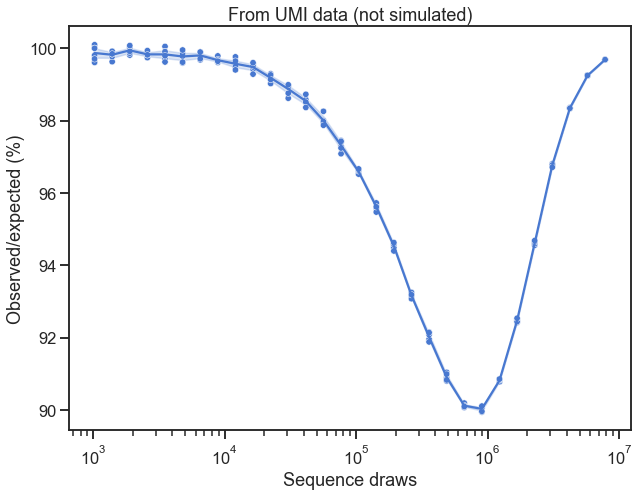

In [7]:
#out_fnam = 'UMI_analysis_plots/UMI_count_analysis_obs-vs-exp_UMI-data.pdf'

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

g1 = sns.lineplot(ax=ax, data=res_df_real, x='Draws', y='Obs/Exp', errorbar=('ci', 95), legend='full');
g2 = sns.scatterplot(ax=ax, data=res_df_real, x='Draws', y='Obs/Exp', legend=False, size=1);
g1.set_xscale('log')
g1.set_ylabel('Observed/expected (%)')
g1.set_xlabel('Sequence draws')
g1.set_title('From UMI data (not simulated)')

fig.tight_layout()
#fig.savefig(out_fnam, bbox_inches='tight')

### Results using real data

The shape of this curve is remarkably similar to the above simulations.
Looking the the positions nucleotide frequencies (see below), they also suggest a non-uniform distribution.
Interestingly, the nucleotide frequencies on each position is remarkably similar with A always being the most frequent, G the least and a coefficient of variance accross the positions of less than 5 %.
So this may just be a function of the base coupling efficiency, [described by IDT](https://www.idtdna.com/pages/products/custom-dna-rna/mixed-bases).

The average spread of nucleotide probabilities at 5.18 (standard deviation x100, see below) is also at a level that makes the curve shape look similar to the simulations above.
But instead of speculating, let us use the average nucleotide probabilities and feed them directly to the simulations.

In [8]:
# Find the positions nucleotide frequencies:
count_mat = lm.alignment_to_matrix(UMI_arr)

/Users/krdav/anaconda3/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


In [10]:
freq_mat = count_mat/len(UMI_arr)
freq_mat

,A,C,G,T
pos,,,,
0,0.310252,0.214457,0.206811,0.268480
1,0.305316,0.227569,0.192388,0.274728
2,0.312457,0.216179,0.195230,0.276134
3,0.310924,0.225463,0.189798,0.273815
4,0.306069,0.228985,0.190862,0.274083
5,0.305790,0.233759,0.186701,0.273750
6,0.308083,0.222371,0.189610,0.279936
7,0.309361,0.227863,0.192711,0.270065
8,0.311093,0.226833,0.188071,0.274003


In [11]:
# Nucleotide frequencies, accross all the positions:
freq_mat.loc[0:8, :].mean()

A    0.308816
C    0.224831
G    0.192465
T    0.273888
dtype: float64

In [12]:
# Calculating the coefficient of variance
# for the nucleotide frequencies accross all the positions
# (expect the last position because it is purines only):
freq_mat.loc[0:8, :].std() / freq_mat.loc[0:8, :].mean() *100

A    0.846985
C    2.753589
G    3.095145
T    1.198975
dtype: float64

In [13]:
# Calculating the average Standard deviation (x100)
freq_mat.std(1)[0:9].mean()*100 # Ignoring the last position, like in simulation

5.178406423654749

Below, I am taking the average nucleotide probabilities and using these to re-run the simulation:

In [14]:
n_bins = 4**9 * 2 # Number of possible sequences
Nreps = 6 # Number of replicate runs (for confidence intervals)
# Number of different sized UMI sequence draws:
ran_size = 30
# range_int = np.linspace(30, 2e5, num=ran_size).astype(int)
# Make the draws evenly spaced in log2 space:
range_int = np.logspace(10, 22.9, num=ran_size, base=2).astype(int)

choices4 = np.arange(4, dtype=np.int8) # All 4 nt. choices
choices2 = np.arange(2, dtype=np.int8) # Just 2 nt. choices

# Plug-in the observed nucleotide frequencies:
p2 = freq_mat.loc[9, ['C', 'T']].values
p2 = p2/p2.sum()
p4 = freq_mat.loc[0:8, :].mean().values
p4 = p4/p4.sum()

# Store the counts and the standard deviations:
res_mat = np.zeros((ran_size, Nreps))
for rep in range(Nreps): # Loop over the replicates
    for res_i, Nseqs in enumerate(range_int): # Loop over the number of sequence draws
        # Generate the UMI sequences as two different matrices:
        a1 = rng_pg.choice(choices4, p=p4, size=(Nseqs, 9))
        a2 = rng_pg.choice(choices2, p=p2, size=(Nseqs, 1))
        # And concatenate them as one matrix of "samples"
        samples = np.concatenate((a1.T, a2.T)).T
        # Count the number of unique UMIs in the samples
        # using a set to deduplicate:
        UMI_set = set()
        for i in range(Nseqs):
            UMI_set.add(samples[i].tobytes())
        res_mat[res_i, rep] = len(UMI_set)

    print('At replicate: {}'.format(rep))

At replicate: 0
At replicate: 1
At replicate: 2
At replicate: 3
At replicate: 4
At replicate: 5


In [15]:
# Turn into dataframe and add the number of 
res_df_sim = pd.DataFrame(res_mat)
res_df_sim['Draws'] = list(range_int)

# Melt dataframe for plotting:
res_df_sim = res_df_sim.melt(id_vars=['Draws'], var_name='Replicate', value_name='Obs')

# Calculate the % observed vs. expected 
# assuming all UMIs arose from different tRNA molecules: 
res_df_sim['Exp'] = [ex_unique(n_bins, Nseqs) for Nseqs in res_df_sim['Draws'].values]
res_df_sim['Obs/Exp'] = 100*res_df_sim['Obs']/res_df_sim['Exp']

In [18]:
# Just checking:
all(res_df_sim['Draws'] == res_df_real['Draws'])

True

In [27]:
res_df_sim['Type'] = 'Simulation'
res_df_real['Type'] = 'Real'
res_df_sim_real = pd.concat((res_df_sim, res_df_real))

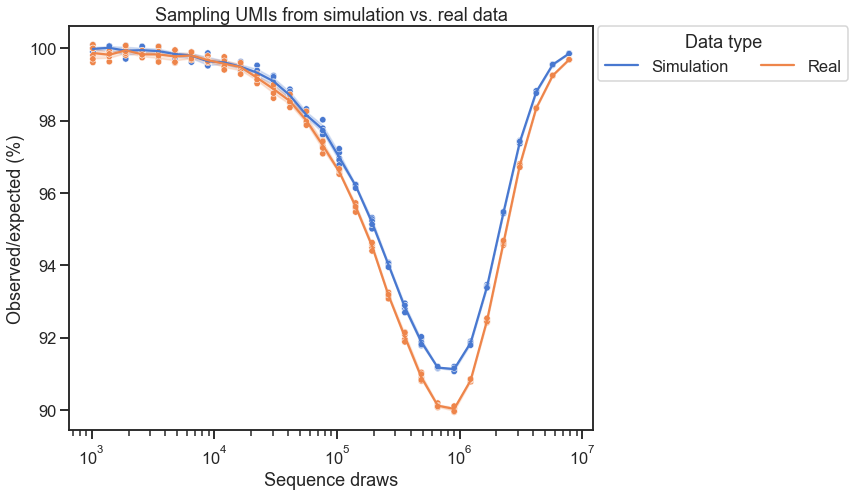

In [29]:
out_fnam = 'UMI_analysis_plots/UMI_count_analysis_obs-vs-exp_UMI-data.pdf'

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

g1 = sns.lineplot(ax=ax, data=res_df_sim_real, x='Draws', y='Obs/Exp', hue='Type', errorbar=('ci', 95), legend='full');
g2 = sns.scatterplot(ax=ax, data=res_df_sim_real, x='Draws', y='Obs/Exp', hue='Type', legend=False, size=1);
g1.set_xscale('log')
g1.set_ylabel('Observed/expected (%)')
g1.set_xlabel('Sequence draws')
g1.set_title('Sampling UMIs from simulation vs. real data')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Data type', bbox_to_anchor=(1.01,1), borderaxespad=0, ncol=2);

fig.tight_layout()
fig.savefig(out_fnam, bbox_inches='tight')

### Conclusions

So these curves look very similar, with a slightly lower observed vs. expected percentage for the real data.
As such this should not be surprising as the real data could have many other non-perfectly random elements e.g. a UMI composed of `TTTTTTTTTT` is hard for the sequencer to actually resolve thus thus might be under-repressented.
Nevertheless, this small residual difference probably means that there is not much positional dependence, if any.